### (PSL) Coding Assignment 3

#### Member
| Field         | Value                |
|---------------|----------------------|
| Name          | Lee Yu Chung, Paul   |
| UID           | 665451160            |
| NetID         | ycl7                 |
| Program       | MCS-DS               |
| Contributions | 100%                 |



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# set random seed
np.random.seed(1160)

In [2]:
# import the data
# consisted of 506 rows (i.e., n = 506) and 14 columns: Y, X1 through X13. No col and row index.
url = "./Coding3_Data.csv"
data = pd.read_csv(url)
print(data.head())
print(data.info())

          x         y
0  0.009496  2.692822
1  0.039996  0.566787
2  0.045770 -0.133373
3  0.113703 -2.696734
4  0.159046 -0.145285
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       30 non-null     float64
 1   y       30 non-null     float64
dtypes: float64(2)
memory usage: 612.0 bytes
None


### Part I: Optimal span for LOESS

1. Write a function to retrieve the Diagonal of the Smoother Matrix. We’re only interested in the
diagonal entries (which will be used in computing LOO-CV and GCV), so this function should return
an n-by-1 vector.
- Inputs: x (an n-by-1 feature vector) and span (a numerical value).
- Output: n-by-1 vector representing the diagonal of the smoother matrix S.
- If you’re using R, please refer to the technique we used for computing the smoother matrix in
smoothing spline models and adapt it for LOESS.
- If you’re using Python, you can either use the aforementioned technique or directly retrieve the
diagonal entries from the output of skmisc.loess [Link]. Keep in mind that the input to this
function should only be x and span, not y. When calling skmisc.loess to retrieve the diagonal
entries, you can use a fake y vector, as the diagonal entries remain the same and do not depend on
the response vector y.

In [3]:
from skmisc.loess import loess

def get_smoother_matrix_diagonal(x: np.ndarray, span: float) -> np.ndarray:
    """Retrieve the diagonal of the smoother matrix.

    Args:
        x (np.ndarray): x (an n-by-1 feature vector) and span (a numerical value).
        span (float): The span parameter for the LOESS model.

    Returns:
        np.ndarray: n-by-1 vector representing the diagonal of the smoother matrix S.
    """
    y = np.zeros_like(x)    
    model  = loess(x, y, span=span)
    model.fit()
    diagonal = model.outputs.diagonal   
    return diagonal


In [4]:
# Testing the smoother matrix diagonal function
x = data['x'].values
span = 0.5
diagonal = get_smoother_matrix_diagonal(x, span)

print(x[:5], "\n", x.shape)
print(diagonal[:5], "\n", diagonal.shape)

[0.00949576 0.03999592 0.04577026 0.11370341 0.159046  ] 
 (30,)
[0.61799136 0.2677504  0.25250909 0.33892068 0.27303055] 
 (30,)


2. Write a function to find the Optimal Span(s) based on CV and GCV.
- Iterate over the speciﬁed span values.
- For each span, calculate the CV and GCV values.
- Return the CV and GCV values corresponding to each span.
- Determine the best span(s) based on the CV and GCV results.

In [5]:
def find_optimal_span(x: np.ndarray, y: np.ndarray, spans: np.ndarray) -> tuple:
    """Find the optimal span based on CV and GCV.

    Args:
        x (np.ndarray): Input features (n-by-1 vector).
        y (np.ndarray): Target values (n-by-1 vector).
        spans (np.ndarray): Array of span values to evaluate.

    Returns:
        tuple: (cv_values, gcv_values, best_span_cv, best_span_gcv)
            cv_values: List of CV values for each span.
            gcv_values: List of GCV values for each span.
            best_span_cv: Optimal span based on CV.
            best_span_gcv: Optimal span based on GCV.
    """
    cv_values = []
    gcv_values = []

    for span in spans:
        S_diag = get_smoother_matrix_diagonal(x, span)
        
        # Fit LOESS model
        model = loess(x, y, span=span)
        model.fit()
        y_pred = model.predict(x).values
        residual = y - y_pred
        
        # Calculate CV
        cv = np.mean((residual / (1 - S_diag))**2)
        cv_values.append(cv)

        # Calculate GCV
        gcv = np.mean((residual / (1 - np.mean(S_diag)))**2)
        gcv_values.append(gcv)

    best_span_cv = spans[np.argmin(cv_values)]
    best_span_gcv = spans[np.argmin(gcv_values)]

    return cv_values, gcv_values, best_span_cv, best_span_gcv


3. Test your code using the provided dataset [Coding3_Data.csv].
- Report your CV and GCV for the following 15 span values: 0.20, 0.25, . . . , 0.90.
- Determine the best span value based on the CV and GCV results. For this dataset, both methods
recommend the same span.

CV values: [12.415910699874145, 2.241473495890149, 1.5029798111583723, 1.259174708469149, 1.1903799279913376, 1.156812123062568, 1.125652340371455, 1.1796637523744404, 1.1794641625428168, 1.2509138273813036, 1.5535622642533475, 1.636174617072946, 1.764533626604454, 1.9760935148587324]
GCV values: [2.110161841942954, 1.4892056326217176, 1.190109844631823, 1.1744229564766888, 1.102539903823101, 1.0625034645069498, 1.0418328786112796, 1.1188405514998323, 1.1192688072551902, 1.180584776931384, 1.5190908128135594, 1.6274293455726156, 1.7445490858435326, 1.925695961353561]
Best span (CV): 0.50
Best span (GCV): 0.50


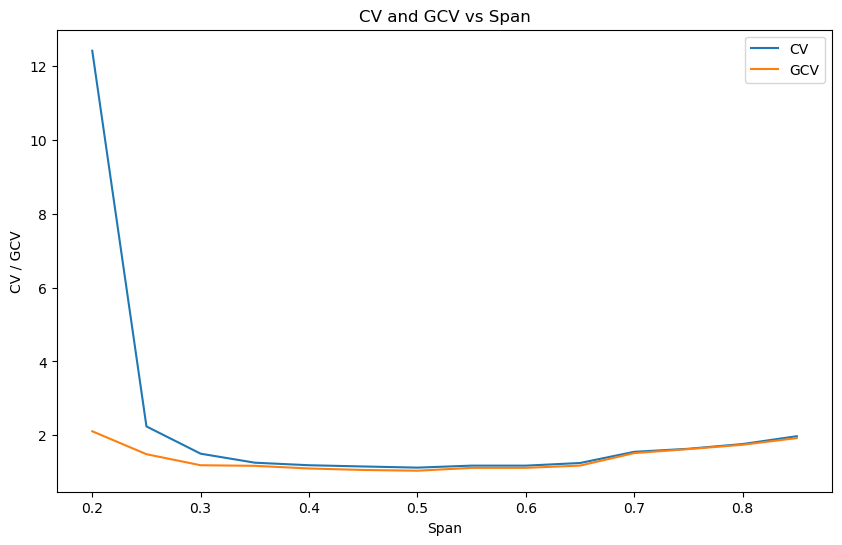

In [6]:
# Searching the optimal span
# spans [0.2, 0.9], 0.05 interval
spans = np.arange(0.2, 0.9, 0.05)
x = data['x']
y = data['y']

cv_values, gcv_values, best_span_cv, best_span_gcv = find_optimal_span(x, y, spans)

# set print precision to 4
print(f"CV values: {cv_values}")
print(f"GCV values: {gcv_values}")
print(f"Best span (CV): {best_span_cv:.2f}")
print(f"Best span (GCV): {best_span_gcv:.2f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(spans, cv_values, label='CV')
plt.plot(spans, gcv_values, label='GCV')
plt.xlabel('Span')
plt.ylabel('CV / GCV')
plt.title('CV and GCV vs Span')
plt.legend()
plt.show()

assert(best_span_cv == best_span_gcv)

- Fit a LOESS model over the entire dataset using the selected optimal span.
- Display the original data points and overlay them with the true curve and the ﬁtted curve. Include a legend to distinguish between the two curves.
- The true curve is
$$
f(x) = \frac{\sin(12(x + 0.2))}{x + 0.2}, \quad x \in [0, 1].
$$
- Note: To display a smooth curve, evaluate your function on a ﬁner grid of points and then plot those points. Your plot may diﬀer from the one shown below, and you are encouraged to use your own color schemes and styles.

In [7]:
# the true curve
def f(x):
    return np.sin(12 * (x + 0.2)) / (x + 0.2)
fx = np.arange(1, 51, 1)/50
fy = f(fx)

In [8]:
# Using the optimal span to fit the model
model = loess(x, y, span=best_span_cv)
model.fit()

# using the finer grid of points for plotting
x_pred = fx
# Ensure x_pred is within the range of x to avoid extrapolation
x_pred = np.clip(x_pred, x.min(), x.max())
y_pred = model.predict(x_pred).values

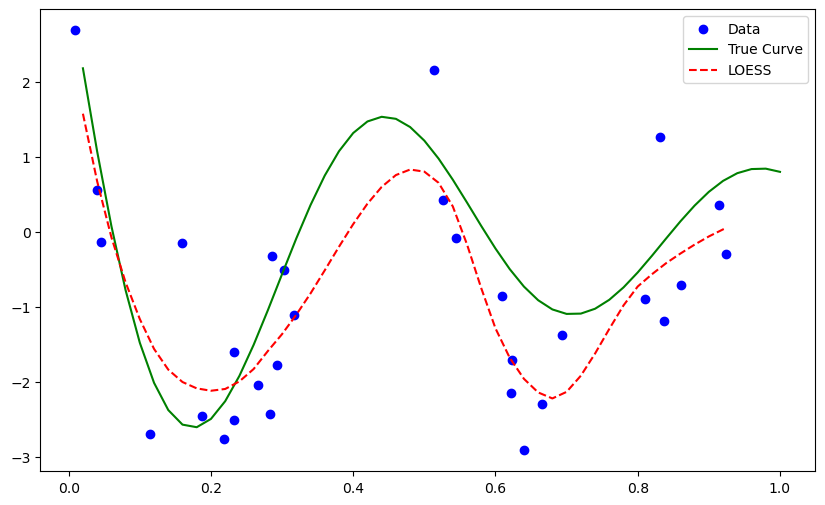

In [9]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Data', color='blue')
plt.plot(fx, fy, label='True Curve', color='green')
plt.plot(x_pred, y_pred, label='LOESS', color='red', linestyle='--')
plt.legend()
plt.show()

### Part II: Ridgeless and double descent

**Objective**

So far in our course, we’ve utilized the U-shaped bias-variance trade-oﬀ curve as a pivotal tool for model selection. This has aided us in methodologies such as ridge/lasso regression, tree pruning, and smoothing splines, among others.

A key observation is that when a model interpolates training data to the extent that the Residual Sum of Squares (RSS) equals zero, it’s typically a red ﬂag signaling overﬁtting. Such models are anticipated to perform inadequately when presented with new, unseen data.

    However, in modern practice, very rich models such as neural networks are trained to exactly ﬁt (i.e., interpolate) the data. Classically, such models would be considered overﬁtted, and yet they often obtain high accuracy on test data. This apparent contradiction has raised questions about the mathematical foundations of machine learning and their relevance to practitioners. (Belkin et al. 2019)

In this assignment, we will use Ridgeless to illustrate the double descent phenomenon. Our setup is similar to, but not the same as, Section 8 in Hastie (2020).

**Data**

Remember the dataset used in Coding 2 Part I? It consisted of 506 rows (i.e., n = 506) and 14 columns: Y ,X1 through X13.

Based on this dataset, we have formed Coding3_dataH.csv, which is structured as follows:
- It contains 506 rows, corresponding to n = 506.
- There are 241 columns in total. The ﬁrst column represents Y . The subsequent 240 columns relate to the NCS basis functions for each of the 13 X variables. The number of knots are individually determined for each feature.

In [10]:
# import the data
# consisted of 506 rows (i.e., n = 506) and 14 columns: Y, X1 through X13. No col and row index.
url_p2 = "./Coding3_dataH.csv"
data_p2 = pd.read_csv(url_p2, header=None)
print(data_p2.head())
print(data_p2.info())

        0    1    2    3         4         5         6         7    8    9    \
0  3.178054  0.0    0  0.0  0.000000  0.000000  0.000000  0.000000  0.0  0.0   
1  3.072693  0.0    0  0.0 -0.007258  0.185217  0.000000  0.001372  0.0  0.0   
2  3.546740  0.0    0  0.0 -0.007258  0.185217  0.000000  0.000000  0.0  0.0   
3  3.508556  0.0    0  0.0 -0.194452  0.005858  0.168630  0.000000  0.0  0.0   
4  3.589059  0.0    0  0.0 -0.194452  0.005858  0.000004  0.000000  0.0  0.0   

   ...       231  232  233       234       235       236  237       238  239  \
0  ...  0.000000  0.0  0.0  0.000000  0.000000  0.047122  0.0  0.000000  0.0   
1  ...  0.000000  0.0  0.0  0.527546  0.000000  0.000000  0.0  0.059271  0.0   
2  ... -0.000028  0.0  0.0  0.527546  0.000000  0.000000  0.0  0.000000  0.0   
3  ...  0.000000  0.0  0.0  0.452800  0.000000  0.000000  0.0  0.000000  0.0   
4  ...  0.000000  0.0  0.0  0.452800  0.003294  0.000000  0.0  0.000000  0.0   

        240  
0  0.000000  
1  0.00000

#### Task 1: Ridgeless Function

Your task is to write a function ridgeless to implement Ridgeless Least Squares, which is equivalent to Principal Component Regression (PCR) using all principal components, with the option scale = FALSE. This means that when computing the principal components (PCs), you center each column of the design matrix without scaling.

- Input: Train and test datasets. In both datasets, the first column represents the response vector Y, and the remaining columns represent the features X.
- Output: Training and test errors, where the error refers to the average squared error.
- You are allowed to use R/Python packages or built-in functions for PCA/SVD, but you are not permitted to use packages or functions specifically designed for linear regression, PCR, or ridge regression.
- Additionally, you are not allowed to perform matrix inversion in your code. After performing PCA/SVD, the resulting design matrix will have orthogonal columns. This allows you to compute the least squares coefficients through simple matrix multiplication, avoiding the need for matrix inversion.
- For numerical stability, you should exclude directions with extremely small eigenvalues (in PCA) or singular values (in SVD). For example, consider using a threshold of eps = 1e-10 for singular values.
- Although training errors aren’t required for our simulation, I recommend including them in the ridgeless output as a helpful debugging tool. Ideally, the training error should match the residual sum of squares (RSS) from a standard linear regression model.

In [11]:
import numpy as np
from sklearn.decomposition import PCA


def ridgeless(train_data: np.ndarray, test_data: np.ndarray, eps: float = 1e-10) -> tuple:
    # Separate features and target
    X_train, y_train = train_data[:, 1:], train_data[:, 0]
    X_test, y_test = test_data[:, 1:], test_data[:, 0]

    # Center the training data and use the same mean for test data
    X_train_mean = np.mean(X_train, axis=0)
    X_train_centered = X_train - X_train_mean
    X_test_centered = X_test - X_train_mean

    # Estimate b0 as the mean of y_train
    b0 = np.mean(y_train)

    # Perform SVD on X_train_centered
    n_components = min(X_train_centered.shape[0], X_train_centered.shape[1])-1
    pca = PCA(n_components=n_components)
    pca.fit(X_train_centered)

    # Identify the number of singular values greater than eps
    k = np.sum(pca.singular_values_ > eps)

    # Truncate V and update the feature matrix
    V_trunc = pca.components_[:k].T
    F = X_train_centered @ V_trunc

    # Compute the LS coefficients
    FtF_inv = 1 / np.sum(F**2, axis=0)
    alpha = FtF_inv * (F.T @ (y_train - b0))

    # Compute predictions on training data
    y_train_pred = b0 + F @ alpha

    # Transform test data and compute predictions
    F_test = X_test_centered @ V_trunc
    y_test_pred = b0 + F_test @ alpha

    # Calculate and return the train/test Mean Squared Prediction Errors
    train_error = np.mean((y_train - y_train_pred)**2)
    test_error = np.mean((y_test - y_test_pred)**2)

    return train_error, test_error

#### Task 2: Simulation study

Execute the procedure below for T = 30 times.

In each iteration,
- Randomly partition the data into training (25%) and test (75%).
- Calculate the log of the test error from the ridgeless function using the ﬁrst d columns of the data, where d ranges from 6 to 241. Keep in mind that the number of regression parameters spans from 5 to 240 because the ﬁrst column represents Y.
- This will result in recording 236 test errors per iteration. These errors are the averaged mean squared errors based on the test data. Store those test errors in a matrix of dimensions 30-by-236.

Graphical display: Plot the median of the test errors (collated over the 30 iterations) in log scale against the count of regression parameters, which spans from 5 to 240.

In [12]:
# Randomly partition the data into training (25%) and test (75%).
train_data = data_p2.sample(frac=0.25, random_state=1160)
test_data = data_p2.drop(train_data.index)

print("Training data shape: ", train_data.shape)
print("Test data shape: ", test_data.shape)

Training data shape:  (126, 241)
Test data shape:  (380, 241)


In [13]:
from sklearn.linear_model import LinearRegression

ridgeless_training_errors = np.zeros((30, 236))
ridgeless_test_errors = np.zeros((30, 236))

lr_training_rss = np.zeros((30, 236))
lr_test_rss = np.zeros((30, 236))
T = 30 # number of iterations

for d in range(6, 241):
    for i in range(T):
        # Randomly partition the data into training (25%) and test (75%).
        train_data = data_p2.sample(frac=0.25, random_state=1160)
        test_data = data_p2.drop(train_data.index)

        # ridgeless
        train_error, test_error = ridgeless(train_data.iloc[:, :d].values, test_data.iloc[:, :d].values)
        ridgeless_training_errors[i][d-6] = train_error
        ridgeless_test_errors[i][d-6] = test_error
        
        # linear regression
        lr_model = LinearRegression()
        lr_model.fit(train_data.iloc[:, 1:d], train_data.iloc[:, 0])
        lr_training_rss[i][d-6] = np.sum((lr_model.predict(train_data.iloc[:, 1:d]) - train_data.iloc[:, 0])**2)
        lr_test_rss[i][d-6] = np.sum((lr_model.predict(test_data.iloc[:, 1:d]) - test_data.iloc[:, 0])**2)


/tmp/ipykernel_350200/836526295.py:8: RuntimeWarning: divide by zero encountered in log
  axs[0, 0].scatter(range(5, 241), np.log(np.median(ridgeless_training_errors, axis=0)), label='Log of Training Error', color='blue', marker='o', alpha=0.5, s=20)
/tmp/ipykernel_350200/836526295.py:14: RuntimeWarning: divide by zero encountered in log
  axs[0, 1].scatter(range(5, 241), np.log(np.median(ridgeless_test_errors, axis=0)), label='Log of TestError', color='blue', marker='o', alpha=0.5, s=20)
/tmp/ipykernel_350200/836526295.py:20: RuntimeWarning: divide by zero encountered in log
  axs[1, 0].scatter(range(5, 241), np.log(np.median(lr_training_rss/T, axis=0)), label='Log of RSS from Linear Regression', color='blue', marker='o', alpha=0.5, s=20)
/tmp/ipykernel_350200/836526295.py:26: RuntimeWarning: divide by zero encountered in log
  axs[1, 1].scatter(range(5, 241), np.log(np.median(lr_test_rss/T, axis=0)), label='Log of Test RSS from Linear Regression', color='blue', marker='o', alpha=0.5,

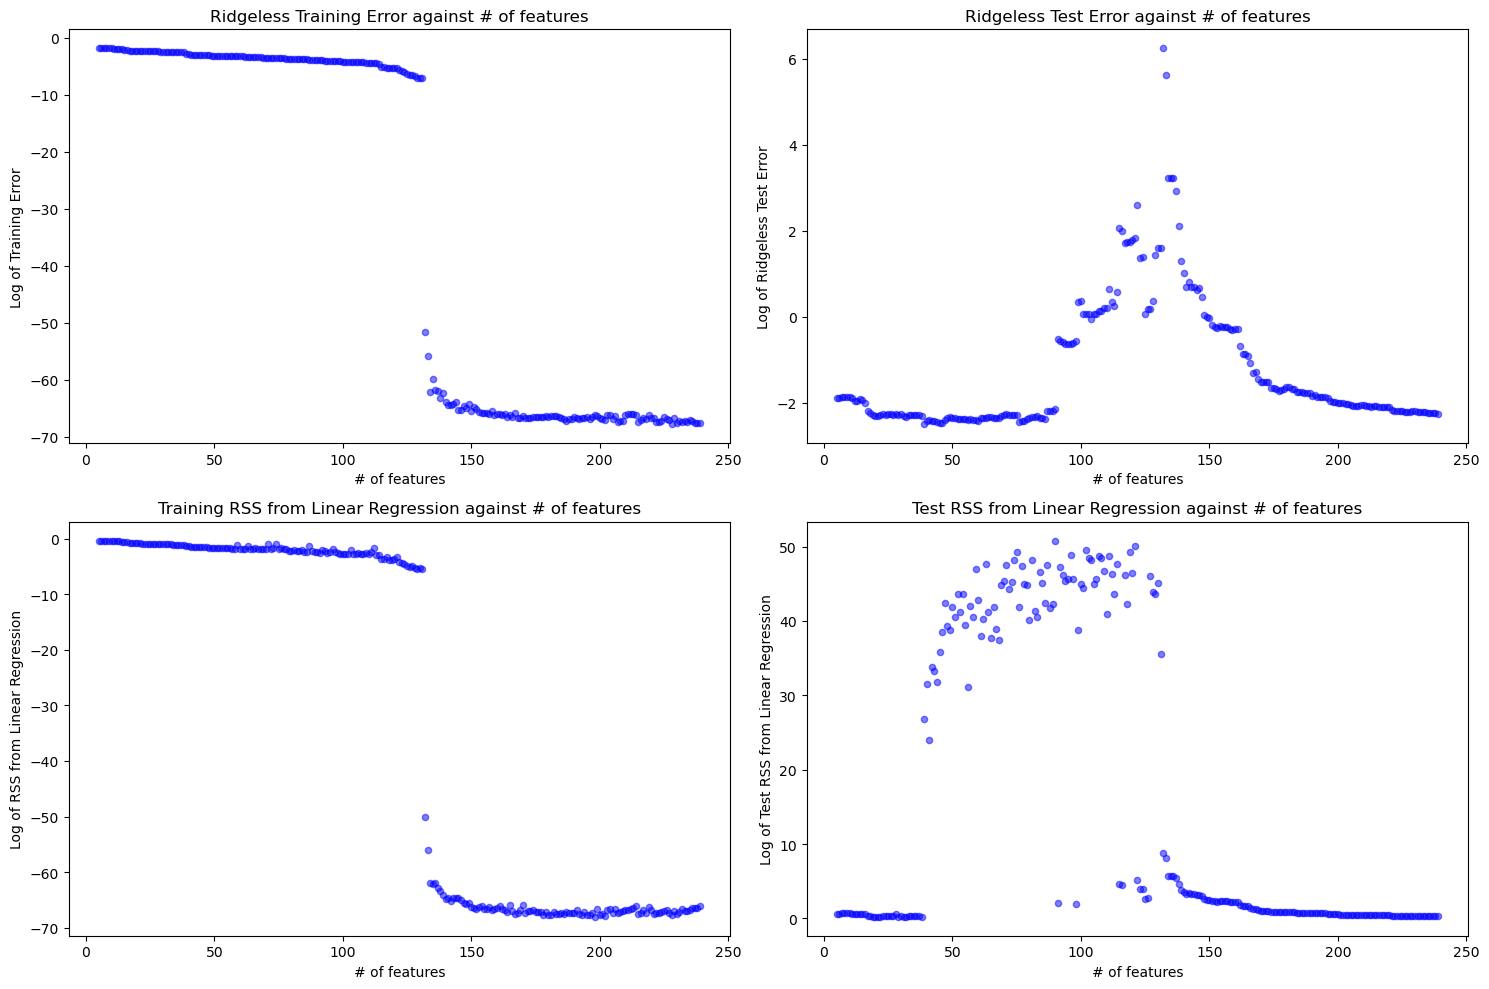

In [14]:
# Top left: Ridgeless Training Error
# Top right: Ridgeless Test Error
# Bottom left: Training RSS from Linear Regression
# Bottom right: Test RSS from Linear Regression
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plotting the Ridgeless Training Error
axs[0, 0].scatter(range(5, 241), np.log(np.median(ridgeless_training_errors, axis=0)), label='Log of Training Error', color='blue', marker='o', alpha=0.5, s=20)
axs[0, 0].set_title('Ridgeless Training Error against # of features')
axs[0, 0].set_xlabel('# of features')
axs[0, 0].set_ylabel('Log of Training Error')

# Plotting the Ridgeless Test Error
axs[0, 1].scatter(range(5, 241), np.log(np.median(ridgeless_test_errors, axis=0)), label='Log of TestError', color='blue', marker='o', alpha=0.5, s=20)
axs[0, 1].set_title('Ridgeless Test Error against # of features')
axs[0, 1].set_xlabel('# of features')
axs[0, 1].set_ylabel('Log of Ridgeless Test Error')

# Plotting the Training RSS from Linear Regression
axs[1, 0].scatter(range(5, 241), np.log(np.median(lr_training_rss/T, axis=0)), label='Log of RSS from Linear Regression', color='blue', marker='o', alpha=0.5, s=20)
axs[1, 0].set_title('Training RSS from Linear Regression against # of features')
axs[1, 0].set_xlabel('# of features') 
axs[1, 0].set_ylabel('Log of RSS from Linear Regression')

# Plotting the Test RSS from Linear Regression
axs[1, 1].scatter(range(5, 241), np.log(np.median(lr_test_rss/T, axis=0)), label='Log of Test RSS from Linear Regression', color='blue', marker='o', alpha=0.5, s=20)
axs[1, 1].set_title('Test RSS from Linear Regression against # of features')
axs[1, 1].set_xlabel('# of features') 
axs[1, 1].set_ylabel('Log of Test RSS from Linear Regression')

plt.tight_layout()
plt.show()


/tmp/ipykernel_12750/942204343.py:3: RuntimeWarning: divide by zero encountered in log
  plt.scatter(range(5, 241), np.log(np.median(ridgeless_test_errors, axis=0)), label='Log of TestError', color='blue', marker='o', alpha=0.5, s=20)


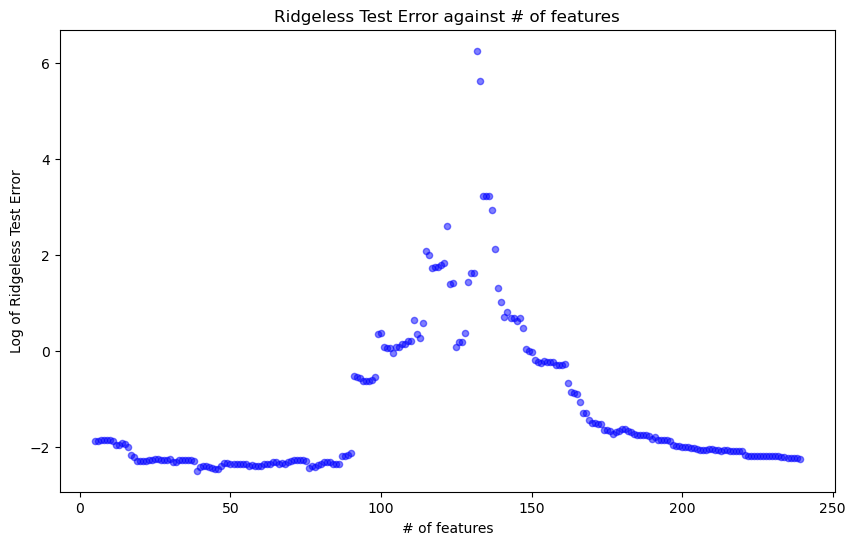

In [15]:
# Plotting the Ridgeless Test Error
plt.figure(figsize=(10, 6))
plt.scatter(range(5, 241), np.log(np.median(ridgeless_test_errors, axis=0)), label='Log of TestError', color='blue', marker='o', alpha=0.5, s=20)
plt.title('Ridgeless Test Error against # of features')
plt.xlabel('# of features')
plt.ylabel('Log of Ridgeless Test Error')
plt.show()

### Part III: Clustering time series

#### Objective
Cluster time series data based on their fluctuation patterns using natural cubic splines.

#### Load Libraries
After loading necessary libraries. We include two pivotal functions: bs and ns. These functions allow us to generate the design matrix for cubic splines and natural cubic splines respectively.

In [15]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from scipy.interpolate import splev, interp1d
from sklearn.linear_model import LinearRegression

In [16]:
# ref: https://github.com/pydata/patsy/blob/6bd31ca7f5f12e77a918681d14b7c28d931bde38/patsy/splines.py
def bs(x, df=None, knots=None, boundary_knots=None, degree=3, include_intercept=False):
    ord = 1 + degree

    if boundary_knots is None:
        boundary_knots = [np.min(x), np.max(x)]
    else:
        boundary_knots = np.sort(boundary_knots).tolist()

    oleft = x < boundary_knots[0]
    oright = x > boundary_knots[1]
    outside = oleft | oright
    inside = ~outside

    if df is not None:
        nIknots = df - ord + (1 - include_intercept)
        if nIknots < 0:
            nIknots = 0

        if nIknots > 0:
            knots = np.linspace(0, 1, num=nIknots + 2)[1:-1]
            knots = np.quantile(x[~outside], knots)

    Aknots = np.sort(np.concatenate((boundary_knots * ord, knots)))
    n_bases = len(Aknots) - (degree + 1)
    if any(outside):
        # print("some 'x' values beyond boundary knots may cause ill-conditioned bases")
        scalef = sp.special.gamma(np.arange(1, ord + 1))[:, None]  # factorials
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        # in theory anything in (0, 1); was (implicitly) 0 in R <= 3.2.2
        e = 1 / 4

        if any(oleft):
            # left pivot inside, i.e., a bit to the right of the boundary knot
            k_pivot = (1 - e) * boundary_knots[0] + e * Aknots[ord]
            xl = np.power.outer(x[oleft] - k_pivot, np.arange(1, degree + 1))
            xl = np.c_[np.ones(xl.shape[0]), xl]

            # equivalent to splineDesign(Aknots, rep(k.pivot, ord), ord, derivs)
            tt = np.empty((xl.shape[1], n_bases), dtype=float)
            for j in range(xl.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)

            basis[oleft, :] = xl @ (tt / scalef)

        if any(oright):
            # right pivot inside, i.e., a bit to the left of the boundary knot
            k_pivot = (1 - e) * boundary_knots[1] + \
                e * Aknots[len(Aknots) - ord - 1]
            xr = np.power.outer(x[oright] - k_pivot, np.arange(1, degree + 1))
            xr = np.c_[np.ones(xr.shape[0]), xr]

            # equivalent to splineDesign(Aknots, rep(k.pivot, ord), ord, derivs)
            tt = np.empty((xr.shape[1], n_bases), dtype=float)
            for j in range(xr.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)
            basis[oright, :] = xr @ (tt / scalef)

        if any(inside):
            xi = x[inside]
            tt = np.empty((len(xi), n_bases), dtype=float)
            for i in range(n_bases):
                coefs = np.zeros((n_bases,))
                coefs[i] = 1
                tt[:, i] = splev(xi, (Aknots, coefs, degree))
            basis[inside, :] = tt
    else:
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        for i in range(n_bases):
            coefs = np.zeros((n_bases,))
            coefs[i] = 1
            basis[:, i] = splev(x, (Aknots, coefs, degree))

    if include_intercept is False:
        basis = basis[:, 1:]

    return basis

In [17]:
# converted from R's ns()
def ns(x, df=None, knots=None, boundary_knots=None, include_intercept=False):
    degree = 3
    
    if boundary_knots is None:
        boundary_knots = [np.min(x), np.max(x)]
    else:
        boundary_knots = np.sort(boundary_knots).tolist()

    oleft = x < boundary_knots[0]
    oright = x > boundary_knots[1]
    outside = oleft | oright
    inside = ~outside

    if df is not None:
        nIknots = df - 1 - include_intercept
        if nIknots < 0:
            nIknots = 0
            
        if nIknots > 0:
            knots = np.linspace(0, 1, num=nIknots + 2)[1:-1]
            knots = np.quantile(x[~outside], knots)

    Aknots = np.sort(np.concatenate((boundary_knots * 4, knots)))
    n_bases = len(Aknots) - (degree + 1)

    if any(outside):
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        e = 1 / 4 # in theory anything in (0, 1); was (implicitly) 0 in R <= 3.2.2

        if any(oleft):
            k_pivot = boundary_knots[0]
            xl = x[oleft] - k_pivot
            xl = np.c_[np.ones(xl.shape[0]), xl]

            # equivalent to splineDesign(Aknots, rep(k.pivot, ord), ord, derivs)
            tt = np.empty((xl.shape[1], n_bases), dtype=float)
            for j in range(xl.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)

            basis[oleft, :] = xl @ tt

        if any(oright):
            k_pivot = boundary_knots[1]
            xr = x[oright] - k_pivot
            xr = np.c_[np.ones(xr.shape[0]), xr]

            tt = np.empty((xr.shape[1], n_bases), dtype=float)
            for j in range(xr.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)
                    
            basis[oright, :] = xr @ tt
        
        if any(inside):
            xi = x[inside]
            tt = np.empty((len(xi), n_bases), dtype=float)
            for i in range(n_bases):
                coefs = np.zeros((n_bases,))
                coefs[i] = 1
                tt[:, i] = splev(xi, (Aknots, coefs, degree))

            basis[inside, :] = tt
    else:
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        for i in range(n_bases):
            coefs = np.zeros((n_bases,))
            coefs[i] = 1
            basis[:, i] = splev(x, (Aknots, coefs, degree))

    const = np.empty((2, n_bases), dtype=float)
    for i in range(n_bases):
        coefs = np.zeros((n_bases,))
        coefs[i] = 1
        const[:, i] = splev(boundary_knots, (Aknots, coefs, degree), der=2)

    if include_intercept is False:
        basis = basis[:, 1:]
        const = const[:, 1:]

    qr_const = np.linalg.qr(const.T, mode='complete')[0]
    basis = (qr_const.T @ basis.T).T[:, 2:]

    return basis

#### Data

Download[Sales_Transactions_Dataset_Weekly.csv]. The original data is from from UCI Machine Learning Repository [Link]

This dataset contains the weekly purchased quantities of 811 products over 52 weeks, resulting in a time series of 52 data points for each product.

Center each time series by removing its mean, and store the resulting data in an 811-by-52 matrix X.

In [18]:
# import the data
url_p3 = "./Sales_Transactions_Dataset_Weekly.csv"
data_p3 = pd.read_csv(url_p3)
print(data_p3.iloc[:5, 0:53])
print(data_p3.info())

  Product_Code  W0  W1  W2  W3  W4  W5  W6  W7  W8  ...  W42  W43  W44  W45  \
0           P1  11  12  10   8  13  12  14  21   6  ...    4    7    8   10   
1           P2   7   6   3   2   7   1   6   3   3  ...    2    4    5    1   
2           P3   7  11   8   9  10   8   7  13  12  ...    6   14    5    5   
3           P4  12   8  13   5   9   6   9  13  13  ...    9   10    3    4   
4           P5   8   5  13  11   6   7   9  14   9  ...    7   11    7   12   

   W46  W47  W48  W49  W50  W51  
0   12    3    7    6    5   10  
1    1    4    5    1    6    0  
2    7    8   14    8    8    7  
3    6    8   14    8    7    8  
4    6    6    5   11    8    9  

[5 rows x 53 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811 entries, 0 to 810
Columns: 107 entries, Product_Code to Normalized 51
dtypes: float64(52), int64(54), object(1)
memory usage: 678.1+ KB
None


In [19]:
# Preprocess the data
# Center each time series by removing its mean
X = data_p3.iloc[:, 1:53].values
X_centered = X - X.mean(axis=1, keepdims=True)

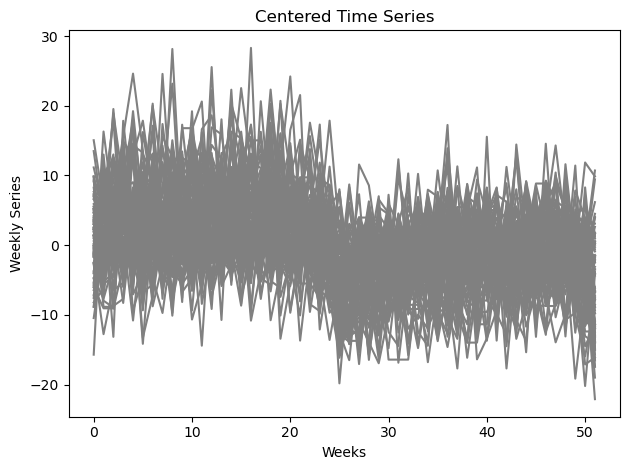

In [82]:
for i in range(100):
    plt.plot(X_centered[i], label=f"Type {i}", color="grey")
plt.title("Centered Time Series")
plt.xlabel("Weeks")
plt.ylabel("Weekly Series")
plt.tight_layout()
plt.show()

#### Task 1: Fitting NCS
- Fit each time series with an NCS with df = 10. This corresponds to an NCS with 8 interior knots. Each row of $X_{811×52}$ represents the response, with the 1-dimensional feature being the index from 1 to 52.
- Store the NCS coeﬃcients (excluding the intercept) in an 811-by-9 matrix $B_{811×9}$.
- Matrix B can be derived as follows:
  - F is a 52-by-9 design matrix without the intercept. For instance, this can be obtained using the ns command with df = 9 and intercept = FALSE.
  - Remove the column mean from F to disregard the intercept.
  - Then compute B via
    $$
    \mathbf{B}^t = (\mathbf{F}^t\mathbf{F})^{-1}\mathbf{F}^t\mathbf{X}^t.
    $$
  - The formula above is given for the transpose of B, since it is equivalent to fitting 811 linear regression models: the design matrix stays the same (i.e., F) but the response vector — there are 811 response vectors corresponding to the 811 rows of X — would vary; each nine dimensional regression coefficient vector corresponds to a row in B (or equivalently, column in $\mathbf{B}^t$).
  - If you do not want to remove the column mean from F, add the intercept column to F and denote the resulting 52-by-10 matrix as $\tilde{\mathbf{F}}$. Then compute the 811-by-10 matrix $\tilde{\mathbf{B}}$:
  $$
  \tilde{\mathbf{B}}^t = (\tilde{\mathbf{F}}^t\tilde{\mathbf{F}})^{-1}\tilde{\mathbf{F}}^t\mathbf{X}^t.
  $$
  - Next, obtain B by dropping the first column of $\tilde{\mathbf{B}}$, as this column corresponds to the intercepts from the 811 regression models.

In [85]:
num_products = 811
num_weeks = 52
num_knots = 9

# Step 1: Create the design matrix F for each time series
F_centered = np.zeros((num_products, num_weeks, num_knots))
for i in range(num_products):
    F = ns(X_centered[i], df=num_knots, include_intercept=False)
    F_centered[i] = F - np.mean(F, axis=1, keepdims=True)
print("F_centered.shape: ", F_centered.shape)

F_centered.shape:  (811, 52, 9)


In [86]:
# Step 2: Compute B for each time series
B = np.zeros((num_products, num_knots))
for i in range(num_products):
    FtF_pinv = np.linalg.pinv(F_centered[i].T @ F_centered[i])
    B_t = FtF_pinv @ F_centered[i].T @ X_centered[i].T
    B[i] = B_t.T  # Transpose to get the 811-by-9 matrix
print("B.shape: ", B.shape)

B.shape:  (811, 9)


#### Task 2: Cluster Matrix B
- Run the k-means algorithm on matrix B to cluster the 811 products into 6 clusters.
- Visualize the centered time series (i.e., rows of X), colored in grey, of products grouped by their clusters. Overlay the plots with the cluster centers (colored in red). Arrange the visualizations in a 2-by-3 format.
- Note: When using matrix B for clustering, the centers are the average of the rows of B within each cluster. To get the corresponding time series from a cluster center b, use the matrix product Fb.

In [87]:
from sklearn.cluster import KMeans

# Run k-means on B
kmeans = KMeans(n_clusters=6, random_state=1160)
kmeans.fit(B)

# check the label
print("kmeans.labels_.shape: ", kmeans.labels_.shape)
print("kmeans.labels_: ", kmeans.labels_[:50])

kmeans.labels_.shape:  (811,)
kmeans.labels_:  [0 5 0 0 0 4 4 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


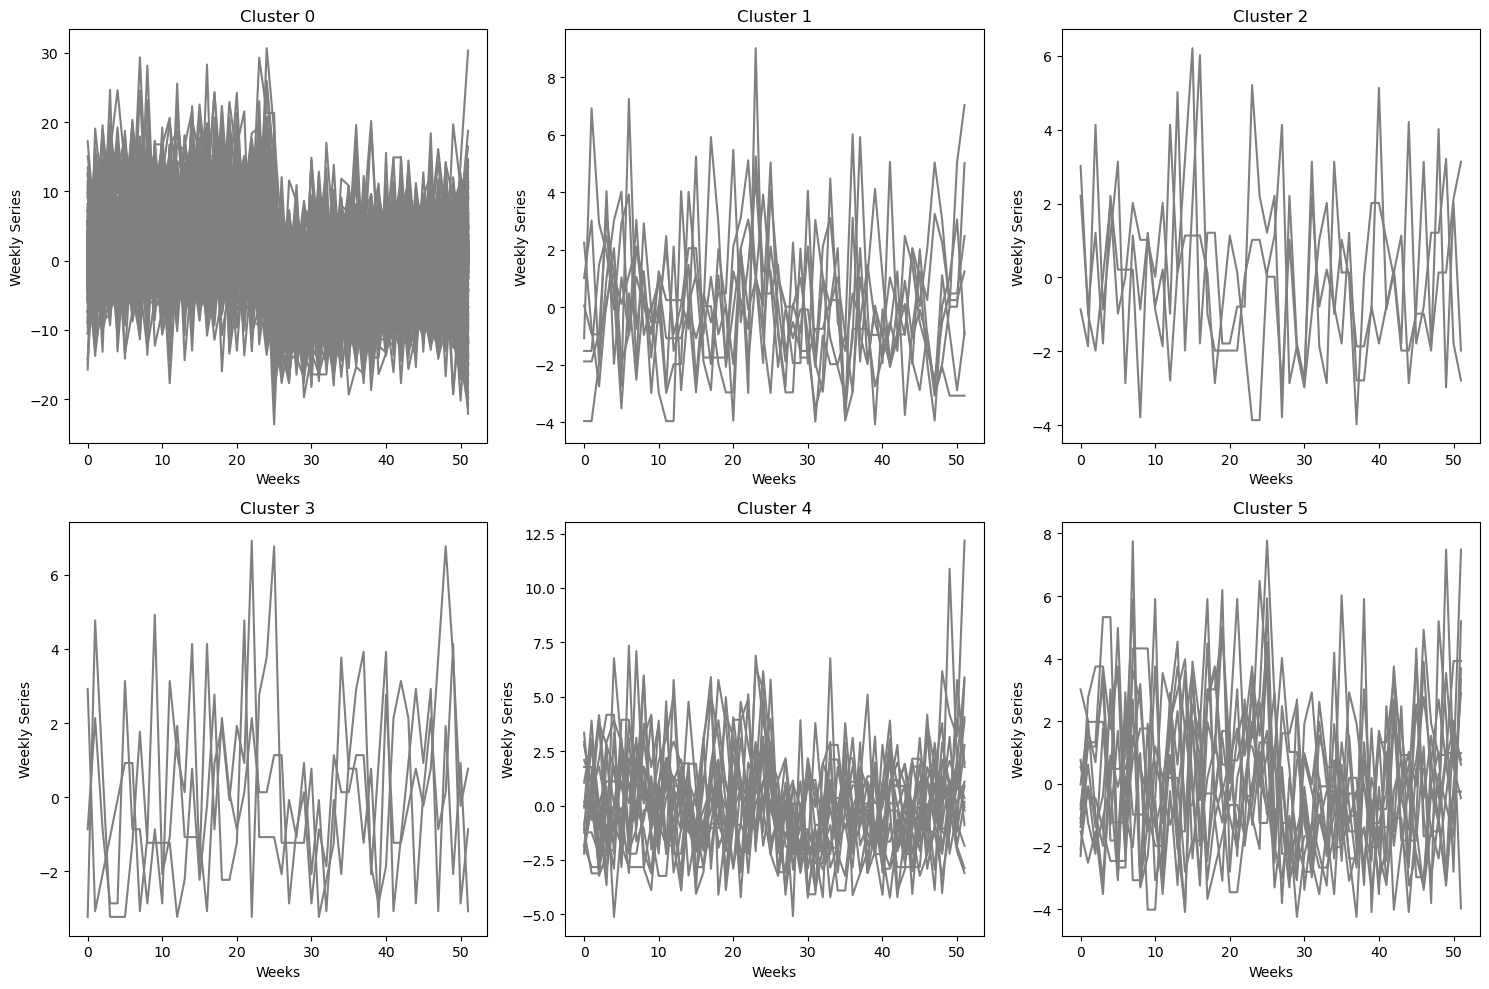

In [88]:
# set the title, xlabel, and ylabel for each subplot
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i in range(6):
    axs[i//3, i%3].set_title(f"Cluster {i}")
    axs[i//3, i%3].set_xlabel("Weeks")
    axs[i//3, i%3].set_ylabel("Weekly Series")

# for each product, plot the time series in the corresponding subplot
for i in range(num_products):
    axs[kmeans.labels_[i]//3, kmeans.labels_[i]%3].plot(X_centered[i], color="grey")
plt.tight_layout()
plt.show()

#### Task 3: Cluster Matrix X
- Run the k-means algorithm on matrix X to cluster the 811 products into 6 clusters.
- Similarly, visualize the centered time series of products grouped by their clusters, accompanied by their respective cluster centers. Arrange the visualizations in a 2-by-3 format.